# setup

In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import sys

from tqdm import tqdm

In [2]:
sys.path.append(os.path.abspath('..'))
from hparams import DATA_ROOT

CSV_PATH = os.path.join(DATA_ROOT, 'records_w_diag_icd10.csv') # The original CSV with codes
H5_PATH = os.path.join(DATA_ROOT, 'mimic_iv_ecg_waveforms.h5')

In [3]:
# The target disease to visualize onset
# I48: Atrial Fibrillation (Best for rhythm visuals)
# I21: Acute MI (Best for ST-segment visuals)
# TARGET_CODE = 'I48' 
# TARGET_NAME = "Atrial Fibrillation"

# --- CONFIGURATION ---
# OPTION 1: Left Bundle Branch Block (Structural Change)
TARGET_CODE = 'I44' 
TARGET_NAME = "Bundle Branch Block / AV Block"

# OPTION 1: right Bundle Branch Block (Structural Change)
# TARGET_CODE = 'I45' 
# TARGET_NAME = "Bundle Branch Block / AV Block"

# OPTION 2: STEMI (Acute Ischemia)
# TARGET_CODE = 'I21'
# TARGET_NAME = "Acute Myocardial Infarction (STEMI)"

# OPTION 3: Tachycardia (Rhythm Change)
# TARGET_CODE = 'I47'
# TARGET_NAME = "Paroxysmal Tachycardia"

def get_codes(code_str):
    try:
        codes = ast.literal_eval(code_str)
        # Truncate to 3 digits to match your training logic
        return set([c[:3] for c in codes if c.startswith('I')])
    except:
        return set()

In [4]:
# 2. Find a "Perfect" Transition Candidate
# We want a pair where:
#   1. Same Patient
#   2. Time gap is reasonable (e.g., < 10 days) so anatomy doesn't change too much
#   3. y_t does NOT have Target
#   4. y_t+1 HAS Target
#   5. The rest of the codes are mostly stable (so we isolate the effect)

df = pd.read_csv(CSV_PATH)
df['ecg_time'] = pd.to_datetime(df['ecg_time'])
df = df.sort_values(['subject_id', 'ecg_time'])

In [ ]:
print(f"Scanning for {TARGET_NAME} ({TARGET_CODE}) onset...")
candidate_indices = []

# Iterate through the DataFrame to find transitions
# (Using a loop is slow but fine for finding one visualization candidate)
for i in (range(len(df) - 1)):
    row_t = df.iloc[i]
    row_next = df.iloc[i+1]
    
    # Check same patient
    if row_t['subject_id'] != row_next['subject_id']:
        continue
        
    codes_t = get_codes(row_t['all_diag_all'])
    codes_next = get_codes(row_next['all_diag_all'])
    
    # Check Onset
    if (TARGET_CODE not in codes_t) and (TARGET_CODE in codes_next):
        
        # Calculate Delta
        added = codes_next - codes_t
        removed = codes_t - codes_next
        
        # We want "clean" examples: Only the target was added, nothing else changed
        # (Or very few changes)
        if (len(added) == 1 and len(removed) == 0) and len(codes_t) > 0 and len(codes_next) < 4:
            candidate_indices.append((i, i+1))
            print(f"Found Candidate at CSV index {i} -> {i+1}")
            print(f"   Time Gap: {row_next['ecg_time'] - row_t['ecg_time']}")
            print(f"   Context: {codes_t} -> {codes_next}")
            
            # Stop after finding a few
            if len(candidate_indices) > 20:
                break


# sample

In [73]:
# 3. Load the Waveforms for the chosen candidate
if not candidate_indices:
    raise ValueError("No transitions found! Try a different code (e.g., I50 for Heart Failure)")

# Pick the first good one
idx_t, idx_next = candidate_indices[5]

row_t = df.iloc[idx_t]
row_next = df.iloc[idx_next]
codes_t = get_codes(row_t['all_diag_all'])
codes_next = get_codes(row_next['all_diag_all'])
print(f"   Context: {codes_t} -> {codes_next}")

   Context: {'I10', 'I48'} -> {'I44', 'I10', 'I48'}


In [74]:
# Need to map CSV index to H5 index (if you have the aligned metadata, use that)
# If not, we assume the monolith was built sorted, so we can search by subject/time
# Or if you have 'mimic_ecg_monolith_metadata.csv', load that to get h5_index directly.

# Robust loading via H5 lookup (assuming standard structure)
# We will just load the specific rows based on the CSV (assuming alignment or re-scan)
# To be safe, let's use the filenames from CSV to confirm
file_t = df.iloc[idx_t]['study_id'] # e.g. files/p100...
file_next = df.iloc[idx_next]['study_id']

print(f"\nVisualizing transition for Subject {df.iloc[idx_t]['subject_id']}...")


Visualizing transition for Subject 11955613...


In [75]:
# We need to find where these files are in the H5
# This search is inefficient but safe for a notebook
with h5py.File(H5_PATH, 'r') as f:
    # Read paths dataset (byte strings)
    # This might take a few seconds
    print("Searching H5 indices...")
    all_paths = f['study_id'][:]
    
    # Handle potential path formatting diffs (strip extensions if needed)
    # The H5 build script usually stored what was in the CSV 'path' column
    
    h5_idx_t = np.where(all_paths == file_t)[0][0]
    h5_idx_next = np.where(all_paths == file_next)[0][0]
    
    # Load Signals
    sig_t = f['waveforms'][h5_idx_t]       # (5000, 12)
    sig_next = f['waveforms'][h5_idx_next] # (5000, 12)

print("Signals Loaded.")

Searching H5 indices...
Signals Loaded.


In [76]:
# 4. Plotting
# Lead II is best for Rhythm (AFib)
# Lead V2 is good for Morphology
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
lead_II_idx = 1 
lead_V2_idx = 7
lead_V1_idx = 6
lead_V6_idx = 11

In [87]:
# Crop to a 3-second window (e.g., 1500 samples) to make it visible
start = 0
duration = 1000 # 3 seconds at 500Hz
end = start + duration

t_axis = np.linspace(0, duration/500, duration)

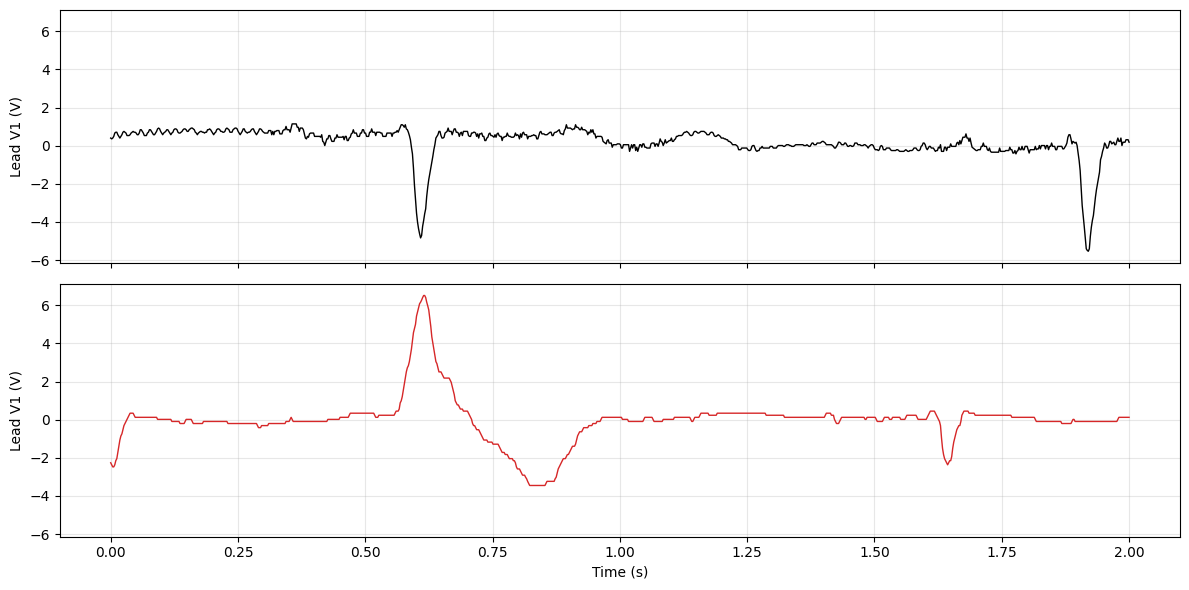

In [88]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)

# Plot State t (Healthy / Baseline)
axes[0].plot(t_axis, sig_t[start:end, lead_V1_idx], color='black', linewidth=1)
# axes[0].plot(t_axis, sig_next[start:end, lead_V2_idx], color='black', linewidth=1)
# axes[0].set_title(f"State $x_t$: Baseline (Normal Sinus Rhythm)", loc='left', fontsize=14, fontweight='bold')
axes[0].set_ylabel("Lead V1 (V)")
axes[0].grid(True, alpha=0.3, which='both')

# axes[0, 1].plot(t_axis, sig_t[start:end, lead_V6_idx], color='black', linewidth=1)

# Visual Marker: Add "Action" Arrow
# We draw an arrow between the plots in the paper composition, 
# but here we title the second plot with the action.

# Plot State t+1 (Pathology)
axes[1].plot(t_axis, sig_next[start:end, lead_V1_idx], color='#d62728', linewidth=1) # Red for danger
# axes[1].plot(t_axis, sig_t[start:end, lead_V2_idx], color='#d62728', linewidth=1) # Red for danger
# axes[1].set_title(f"State $x_{{t+1}}$: After Action $a_t$ (Onset of {TARGET_NAME})", loc='left', fontsize=14, fontweight='bold')
axes[1].set_ylabel("Lead V1 (V)")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True, alpha=0.3, which='both')
# axes[1, 1].plot(t_axis, sig_next[start:end, lead_V6_idx], color='#d62728', linewidth=1) # Red for danger

# Add "Clinical Note" annotations (Optional)
if TARGET_CODE == 'I48':
    axes[0].text(0.5, 2, "Regular R-R, Distinct P-waves", fontsize=10, color='blue')
    axes[1].text(0.5, 2, "Irregular R-R, Fibrillatory waves (No P)", fontsize=10, color='red')

plt.tight_layout()
plt.savefig("qualitative_transition.png", dpi=300)
plt.show()

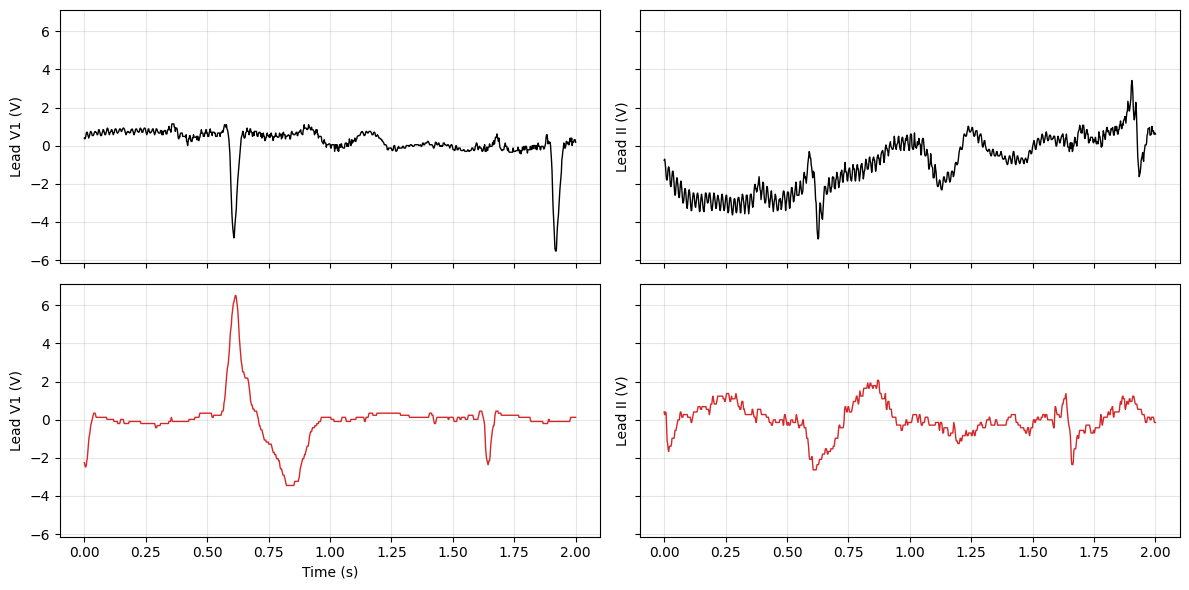

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot State t (Healthy / Baseline)
axes[0, 0].plot(t_axis, sig_t[start:end, lead_V1_idx], color='black', linewidth=1)
# axes[0].plot(t_axis, sig_next[start:end, lead_V2_idx], color='black', linewidth=1)
# axes[0].set_title(f"State $x_t$: Baseline (Normal Sinus Rhythm)", loc='left', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel("Lead V1 (V)")
axes[0, 0].grid(True, alpha=0.3, which='both')

axes[0, 1].plot(t_axis, sig_t[start:end, lead_II_idx], color='black', linewidth=1)
axes[0, 1].set_ylabel("Lead II (V)")
axes[0, 1].grid(True, alpha=0.3, which='both')

# Visual Marker: Add "Action" Arrow
# We draw an arrow between the plots in the paper composition, 
# but here we title the second plot with the action.

# Plot State t+1 (Pathology)
axes[1, 0].plot(t_axis, sig_next[start:end, lead_V1_idx], color='#d62728', linewidth=1) # Red for danger
# axes[1].plot(t_axis, sig_t[start:end, lead_V2_idx], color='#d62728', linewidth=1) # Red for danger
# axes[1].set_title(f"State $x_{{t+1}}$: After Action $a_t$ (Onset of {TARGET_NAME})", loc='left', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel("Lead V1 (V)")
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].grid(True, alpha=0.3, which='both')

axes[1, 1].plot(t_axis, sig_next[start:end, lead_II_idx], color='#d62728', linewidth=1) # Red for danger
axes[1, 1].set_ylabel("Lead II (V)")
axes[1, 1].grid(True, alpha=0.3, which='both')

# Add "Clinical Note" annotations (Optional)
if TARGET_CODE == 'I48':
    axes[0].text(0.5, 2, "Regular R-R, Distinct P-waves", fontsize=10, color='blue')
    axes[1].text(0.5, 2, "Irregular R-R, Fibrillatory waves (No P)", fontsize=10, color='red')

plt.tight_layout()
plt.savefig("qualitative_transition.png", dpi=300)
plt.show()